# ML Pipeline Preparation
ML for loading clean data from database, preparing it for classification task, training and evaluating a classifier and saving resultant model.
### 1. Load data from database.

In [1]:
# import libraries
import sqlite3
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE, ADASYN

import spacy
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, make_scorer, hamming_loss, recall_score

Using TensorFlow backend.


In [2]:
# load data from database
conn = sqlite3.connect('../data/DisasterResponse.db')
df = pd.read_sql_query('SELECT * FROM message', conn, index_col='id')
X = df.message
Y = df.loc[:, 'related':]

In [3]:
X.head()

id
2     Weather update - a cold front from Cuba that c...
7               Is the Hurricane over or is it not over
8                       Looking for someone but no name
9     UN reports Leogane 80-90 destroyed. Only Hospi...
12    says: west side of Haiti, rest of the country ...
Name: message, dtype: object

In [4]:
Y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
def remove_single_value_columns(df):
    """Remove single value columns
    
    Args:
        df (pd.DataFrame): input frame
        
    Returns:
        df_out (pd.DataFrame): clean dataframe with removed single value columns
    """
    remove_cols = []
    
    for col in df:
        if len(df[col].value_counts()) == 1:
            remove_cols.append(col)
            
    df_out = df.drop(columns=remove_cols)
    
    return df_out

In [6]:
Y = remove_single_value_columns(Y)
Y.shape

(26174, 35)

### 2. Write a tokenization function to process text data

In [7]:
def tokenize(text):
    """ Return lowercase lemmatized tokens of the input text. 
        Remove punctuation, spacy.stop_words, and pronouns.
    
    Args:
        text (str): input text
    Returns:
        tokens ([str]): list of lower case lemmatized tokens
    """
    
    doc = nlp(text)
    tokens = [tok.lemma_.lower() for tok in doc
              if (not tok.is_stop) and (not tok.is_punct) and (tok.lemma_ != '-PRON-')]
    return tokens

In [8]:
# test tokenize()
text = X.iloc[0]
print(text, '\n', tokenize(text))

Weather update - a cold front from Cuba that could pass over Haiti 
 ['weather', 'update', 'cold', 'cuba', 'pass', 'haiti']


### 3. Build a machine learning pipeline
This machine pipeline takes `message` column as input and outputs classification results on 36 categories in the dataset.

In [9]:
# Simple pipeline to classify messages with Count Vectorizer --> Complement Naive Bayes
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(ComplementNB()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [10]:
# Unstratified split of data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

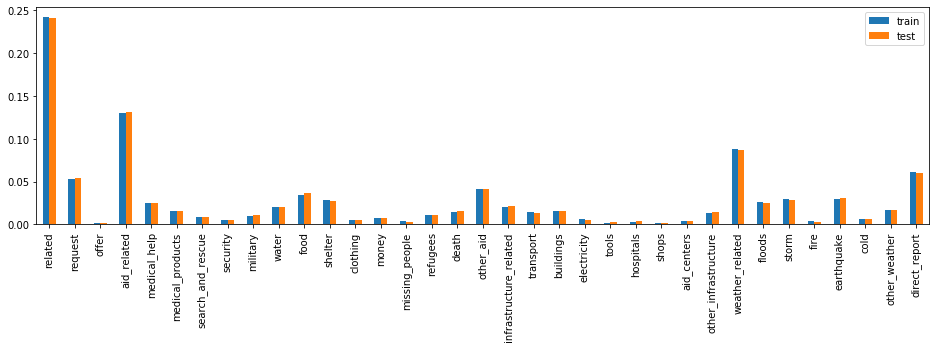

In [11]:
# check that proportion of positive classes over targets is similar between train and tests sets
pd.DataFrame({'train': Y_train.sum()/Y_train.sum().sum(), 
              'test': Y_test.sum()/Y_test.sum().sum()}).plot(kind='bar', figsize=(16,4));

It appears that base train_test_split retains a similar ratio of positive and negative classes for all output targets. Thus, we expect, this method to generate a representative test set for model generalization evaluation.

In [12]:
# train pipeline
%time pipeline.fit(X_train, Y_train)

Wall time: 4min 18s


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x000002438852F9D8>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultiOutputClassifier(estimator=ComplementNB(alpha=1.0,
          

### 5. Test model

In [13]:
%time preds = pd.DataFrame(pipeline.predict(X_test), columns=Y_test.columns.copy())

report = classification_report(Y_test, preds, target_names=Y_test.columns.copy())

Wall time: 1min 23s


C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
print(report)

                        precision    recall  f1-score   support

               related       0.83      0.95      0.89      4937
               request       0.65      0.55      0.60      1119
                 offer       0.00      0.00      0.00        23
           aid_related       0.67      0.76      0.71      2686
          medical_help       0.38      0.14      0.21       503
      medical_products       0.27      0.09      0.13       319
     search_and_rescue       0.00      0.00      0.00       177
              security       0.00      0.00      0.00       113
              military       0.34      0.14      0.20       223
                 water       0.34      0.12      0.17       421
                  food       0.56      0.34      0.42       739
               shelter       0.47      0.21      0.29       554
              clothing       0.30      0.22      0.25        97
                 money       0.07      0.02      0.03       157
        missing_people       0.00      

In [15]:
print(f'Hamming Loss: {hamming_loss(Y_test, preds)}')

Hamming Loss: 0.06619367796018162


In [16]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x000002438852F9D8>,
                   vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=ComplementNB(alpha=1.0, class_prior=None,
                                                fit_prior=True, norm=False),
                         n_jobs=None))],
 'verbose': False,
 'vect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='co

Both cross-validation and test set splits do not account for class imbalance and are not stratified in the approach above, leading to poor model training.

Additionally, Hamming Loss scorer maybe too soft, leading to higher precision but lower recall. Since classification of messages is likely to be used to provide relief during natural disasters, it is more important to alert an appropriate agency of potential need and not miss any categories even if we create a false alert, rather than not place a message in a category and not alerting of a need when there is one. Thus, **recall is more important than precision in our classification**. Model selection will be used with emphasis on high recall score.

### 6. Model Improvements:
* use recall metric
* try resampling with imblearn
* try other machine learning algorithms

In [17]:
from sklearn.multioutput import (MultiOutputClassifier, _fit_estimator)
from sklearn.utils.validation import (check_X_y, has_fit_parameter,
                                      _check_fit_params)
from sklearn.utils.multiclass import check_classification_targets
from sklearn.base import is_classifier

from joblib import Parallel, delayed

# Create one vs. all strategy multi-output classifier capable of re-sampling data
# *separately* for each target output using imblearn samplers

class ImbalancedMultiOutputClassifier(MultiOutputClassifier):
    """Multi target classification with class imbalanced targets.
    This strategy consists of resampling data and fitting one classifier per target. 
    
    Args:
        estimator : estimator object implementing 
                    :term:`fit`, :term:`score` and :term:`predict_proba`    
        sampler : imblearn sampler object (SMOTE, ADASYN, etc.) with fit_resample() method
        n_jobs : int or None, optional (default=None)
            The number of jobs to use for the computation.
            It does each target variable in y in parallel.
            ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
            ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
            for more details.
    
    Attributes:
        estimators_ : list of ``n_output`` estimators. Estimators used for predictions.
        sampler : imblearn resampler with fit_resample() method
    
    Returns:
        None

    """

    def __init__(self, estimator, n_jobs=None, sampler=None):
        super().__init__(estimator, n_jobs)
        self.sampler = sampler

    def fit(self, X, y, sample_weight=None, **fit_params):
        """ Fit the model to data.
        Fit a separate model for each output variable.
        Parameters
        ----------
        X : (sparse) array-like, shape (n_samples, n_features)
            Data.
        y : (sparse) array-like, shape (n_samples, n_outputs)
            Multi-output targets. An indicator matrix turns on multilabel
            estimation.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
            Only supported if the underlying regressor supports sample
            weights.
        **fit_params : dict of string -> object
            Parameters passed to the ``estimator.fit`` method of each step.
        Returns
        -------
        self : object
        """
        if not hasattr(self.estimator, "fit"):
            raise ValueError("The base estimator should implement"
                             " a fit method")

        X, y = check_X_y(X, y,
                         multi_output=True,
                         accept_sparse=True)

        if is_classifier(self):
            check_classification_targets(y)

        if y.ndim == 1:
            raise ValueError("y must have at least two dimensions for "
                             "multi-output regression but has only one.")

        if (sample_weight is not None and
                not has_fit_parameter(self.estimator, 'sample_weight')):
            raise ValueError("Underlying estimator does not support"
                             " sample weights.")

        fit_params_validated = _check_fit_params(X, fit_params)

        if self.sampler is None:
            self.estimators_ = Parallel(n_jobs=self.n_jobs)(
                delayed(_fit_estimator)(
                    self.estimator, 
                    X, y[:, i],  # fit to raw input data
                    sample_weight,
                    **fit_params_validated)
                for i in range(y.shape[1]))
        else:
            # Resampling...
            # calling self.sampler.fit_resample(X, y[:, i])
            self.estimators_ = Parallel(n_jobs=self.n_jobs)(
                delayed(_fit_estimator)(
                    self.estimator,
                    *self.sampler.fit_resample(X, y[:, i]),  # fit to resampled data
                    sample_weight,
                    **fit_params_validated)
                for i in range(y.shape[1]))
        return self

Test ImbalancedMultiOutputClassifier with data resampling for each estimator/target pair.

In [18]:
clf_imb = ImbalancedMultiOutputClassifier(estimator=ComplementNB(), sampler=SMOTE(random_state=42))

In [19]:
clf_imb.sampler

SMOTE(k_neighbors=5, n_jobs=None, random_state=42, sampling_strategy='auto')

In [20]:
vect = CountVectorizer(tokenizer=tokenize)
%time X_vect = vect.fit_transform(X_train)
%time X_vect_test = vect.transform(X_test)

tfidf = TfidfTransformer()
%time X_tfidf = tfidf.fit_transform(X_vect)
%time X_tfidf_test = tfidf.transform(X_vect_test)

Wall time: 4min 9s
Wall time: 1min 16s


In [35]:
%time clf_imb.fit(X_tfidf, Y_train)
%time preds_imb = pd.DataFrame(clf_imb.predict(X_tfidf_test), columns=Y_test.columns.copy())
report_imb = classification_report(Y_test, preds_imb, target_names=Y_test.columns.copy())
print(report_imb)
print(f'Hamming Loss: {hamming_loss(Y_test, preds_imb)}')

Wall time: 13.7 s
Wall time: 125 ms
                        precision    recall  f1-score   support

               related       0.89      0.86      0.87      4937
               request       0.48      0.79      0.59      1119
                 offer       0.02      0.22      0.04        23
           aid_related       0.64      0.83      0.72      2686
          medical_help       0.23      0.72      0.35       503
      medical_products       0.17      0.71      0.27       319
     search_and_rescue       0.08      0.47      0.14       177
              security       0.04      0.35      0.08       113
              military       0.22      0.80      0.34       223
                 water       0.24      0.80      0.37       421
                  food       0.37      0.81      0.50       739
               shelter       0.27      0.83      0.41       554
              clothing       0.12      0.71      0.21        97
                 money       0.10      0.61      0.18       157
   

C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We observe a double digit increase in recall scores for model using SMOTE synthetic oversampling, especially for extremely imbalanced (low positive class rate) targets. However, resultant models reduces precision and overall F1 score, suggesting that base SMOTE is too aggressive.

In [36]:
clf_imb_adasyn = ImbalancedMultiOutputClassifier(estimator=ComplementNB(), sampler=ADASYN(random_state=42))
%time clf_imb_adasyn.fit(X_tfidf, Y_train)
%time preds_imb_adasyn = pd.DataFrame(clf_imb_adasyn.predict(X_tfidf_test), columns=Y_test.columns.copy())
report_imb_adasyn = classification_report(Y_test, preds_imb_adasyn, target_names=Y_test.columns.copy())
print(report_imb_adasyn)

Wall time: 46 s
Wall time: 80.5 ms
                        precision    recall  f1-score   support

               related       0.89      0.85      0.87      4937
               request       0.47      0.79      0.59      1119
                 offer       0.02      0.17      0.03        23
           aid_related       0.66      0.79      0.72      2686
          medical_help       0.23      0.73      0.35       503
      medical_products       0.17      0.71      0.27       319
     search_and_rescue       0.08      0.46      0.14       177
              security       0.05      0.36      0.08       113
              military       0.22      0.80      0.34       223
                 water       0.24      0.81      0.37       421
                  food       0.35      0.82      0.49       739
               shelter       0.27      0.84      0.41       554
              clothing       0.12      0.72      0.21        97
                 money       0.10      0.61      0.18       157
    

C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
clf_rf = ImbalancedMultiOutputClassifier(estimator=RandomForestClassifier(), sampler=None)
%time clf_rf.fit(X_tfidf, Y_train)
%time preds_rf = pd.DataFrame(clf_rf.predict(X_tfidf_test), columns=Y_test.columns.copy())
report_rf = classification_report(Y_test, preds_rf, target_names=Y_test.columns.copy())
print(report_rf)

Wall time: 6min 57s
Wall time: 20.2 s
                        precision    recall  f1-score   support

               related       0.85      0.94      0.89      4937
               request       0.82      0.48      0.61      1119
                 offer       0.00      0.00      0.00        23
           aid_related       0.75      0.69      0.72      2686
          medical_help       0.61      0.07      0.13       503
      medical_products       0.66      0.07      0.12       319
     search_and_rescue       0.80      0.07      0.12       177
              security       0.00      0.00      0.00       113
              military       0.62      0.07      0.13       223
                 water       0.91      0.38      0.53       421
                  food       0.82      0.65      0.73       739
               shelter       0.80      0.36      0.50       554
              clothing       0.58      0.07      0.13        97
                 money       1.00      0.03      0.05       157
 

C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
clf_rf_smote = ImbalancedMultiOutputClassifier(estimator=RandomForestClassifier(), sampler=SMOTE())
%time clf_rf_smote.fit(X_tfidf, Y_train)
%time preds_rf_smote = pd.DataFrame(clf_rf_smote.predict(X_tfidf_test), columns=Y_test.columns.copy())
report_rf_smote = classification_report(Y_test, preds_rf_smote, target_names=Y_test.columns.copy())
print(report_rf_smote)

Wall time: 18min 30s
Wall time: 16.6 s
                        precision    recall  f1-score   support

               related       0.87      0.90      0.89      4937
               request       0.67      0.64      0.66      1119
                 offer       0.00      0.00      0.00        23
           aid_related       0.72      0.73      0.73      2686
          medical_help       0.61      0.29      0.39       503
      medical_products       0.62      0.25      0.36       319
     search_and_rescue       0.56      0.11      0.18       177
              security       0.33      0.02      0.03       113
              military       0.58      0.22      0.32       223
                 water       0.79      0.57      0.66       421
                  food       0.80      0.72      0.75       739
               shelter       0.74      0.52      0.61       554
              clothing       0.57      0.27      0.36        97
                 money       0.67      0.08      0.14       157


C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 7. Export model as a pickle file

In [37]:
# with open('../models/model_01.pkl', 'wb') as file:
#     pickle.dump(cv, file)